When exploring a large set of documents -- such as Wikipedia, news articles, StackOverflow, etc. -- it can be useful to get a list of related material. To find relevant documents you typically
* Decide on a notion of similarity
* Find the documents that are most similar 

In the assignment you will
* Gain intuition for different notions of similarity and practice finding similar documents. 
* Explore the tradeoffs with representing documents using raw word counts and TF-IDF
* Explore the behavior of different distance metrics by looking at the Wikipedia pages most similar to President Obama’s page.

In [247]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import euclidean
from sympy.benchmarks.bench_meijerint import alpha
%matplotlib inline

## Load Wikipedia dataset

We will be using the dataset of abridged Wikipedia pages. Each element of the dataset consists of a link to the wikipedia article, the name of the person, and the text of the article (in lowercase).  

In [248]:
wiki = pd.read_csv('data/people_wiki.csv')
wiki.head()

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former australian rules footballer who played with the k...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from university of chicago in 1973 after studying psychia...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player who has been active in canadas blues scene since ...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lower austria austria on 18 january 1942 is an austria...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn better known by his stagename genka is an estonian...


If you want to check whether the text on the webpage agrees with the one here, you can display it with the following code:

In [249]:
# from IPython.display import HTML
# print(wiki['text'][0])
# HTML(url=wiki['URI'][0])

## Ex. 1: Extract word count vectors

As we have seen in Assignment 4, we can extract word count vectors using `CountVectorizer` function.
- make sure you include words of unit length by using the parameter: `token_pattern=r"(?u)\b\w+\b"`
- do not use any stopwords
- take 10000 most frequent words in the corpus
- explicitly take all the words independent of in how many documents they occur
- obtain the matrix of word counts

In [250]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(
    max_features = 10000, # Only include 10,000 most frequent words
    token_pattern=r"(?u)\b\w+\b" # Include unit-length words
   )
WCmatrix = vectorizer.fit_transform(wiki['text'])

## Ex. 2: Find nearest neighbors

**a)** Start by finding the nearest neighbors of the Barack Obama page using the above word count matrix to represent the articles and **Euclidean** distance to measure distance.
Save the distances in `wiki['BO-eucl']` and look at the top 10 nearest neighbors.

In [251]:
# One can use the following:
    # from sklearn.neighbors import NearestNeighbors
    # nbrs = NearestNeighbors(n_neighbors=3, algorithm='brute',metric='euclidean').fit(X.toarray())
    # distances, indices = nbrs.kneighbors(X.toarray())
# but here let's use:
from sklearn.metrics import pairwise_distances

obama_idx = wiki[wiki['name']=='Barack Obama'].index[0]

dist = pairwise_distances(WCmatrix[obama_idx], WCmatrix, metric='euclidean').flatten()

wiki['BO-eucl'] = dist


In [252]:

top_neighbors = wiki.nsmallest(10, 'BO-eucl')
print(top_neighbors[['name', 'BO-eucl', 'text']])


      name                BO-eucl    \
35817       Barack Obama   0.000000   
24478          Joe Biden  31.336879   
28447     George W. Bush  33.645208   
48202       Tony Vaccaro  33.734256   
14754        Mitt Romney  34.351128   
31423     Walter Mondale  34.423829   
36364         Don Bonker  34.597688   
13229   Francisco Barrio  34.669872   
35357   Lawrence Summers  35.383612   
25258  Marc Ravalomanana  35.440090   

      text                                                                                                  
35817  barack hussein obama ii brk husen bm born august 4 1961 is the 44th and current president of the...  
24478  joseph robinette joe biden jr dosf rbnt badn born november 20 1942 is the 47th and current vice ...  
28447  george walker bush born july 6 1946 is an american politician and businessman who served as the ...  
48202  michelantonio celestino onofrio vaccaro born december 20 1922 better known as tony vaccaro or mi...  
14754  willard mitt romne

**b)** Measure the pairwise distance between the Wikipedia pages of Barack Obama, George W. Bush, and Joe Biden. Which of the three pairs has the smallest distance?

In [253]:
obama_idx = wiki[wiki['name']=='Barack Obama'].index[0]
bush_idx = wiki[wiki['name']=='George W. Bush'].index[0]
biden_idx = wiki[wiki['name']=='Joe Biden'].index[0]

obama_biden_dist = pairwise_distances(WCmatrix[obama_idx], WCmatrix[biden_idx], metric='euclidean')[0][0]
obama_bush_dist = pairwise_distances(WCmatrix[obama_idx], WCmatrix[bush_idx], metric='euclidean')[0][0]
bush_biden_dist = pairwise_distances(WCmatrix[bush_idx], WCmatrix[biden_idx], metric='euclidean')[0][0]

print("Obama-Biden distance: ", obama_biden_dist)
print("Obama-Bush distance: ", obama_bush_dist)
print("Bush-Biden distance: ", bush_biden_dist)

Obama-Biden distance:  31.336879231984796
Obama-Bush distance:  33.645207682521445
Bush-Biden distance:  30.919249667480614


All of the 10 people from **a)** are politicians, but about half of them have rather tenuous connections with Obama, other than the fact that they are politicians, e.g.,

* Francisco Barrio is a Mexican politician, and a former governor of Chihuahua.
* Walter Mondale and Don Bonker are Democrats who made their career in late 1970s.

Nearest neighbors with raw word counts got some things right, showing all politicians in the query result, but missed finer and important details.

**c)** Let's find out why Francisco Barrio was considered a close neighbor of Obama.
To do this, look at the most frequently used words in each of Barack Obama and Francisco Barrio's pages.

In [254]:
def top_words(name):
    """
    Get a table of the most frequent words in the given person's wikipedia page.
    """
    person_idx = wiki[wiki['name']==name].index[0]
    word_counts = WCmatrix[person_idx].toarray().flatten()
    words = pd.DataFrame({
        'word': vectorizer.get_feature_names_out(),
        'count': word_counts
    })
    
    return words.sort_values(by='count',ascending=False)

In [255]:
obama_words = top_words('Barack Obama').set_index('word')
obama_words

,count
word,
the,40
in,30
and,21
of,18
to,14
...,...
ethnic,0
eton,0
eu,0


In [256]:
barrio_words = top_words('Francisco Barrio').set_index('word')
barrio_words

,count
word,
the,36
of,24
and,18
in,17
he,10
...,...
estate,0
estimated,0
estonia,0


**d)** Extract the list of most frequent **common** words that appear in both Obama's and Barrio's documents and display the five words that appear most often in Barrio's article.

Use a dataframe operation known as **join**. The **join** operation is very useful when it comes to playing around with data: it lets you combine the content of two tables using a shared column (in this case, the index column of words). See [the documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) for more details.

In [257]:
# Modify the code to avoid error.

common_words = obama_words.join(barrio_words, lsuffix='_Obama', rsuffix='_Barrio')

common_words.sort_values(by='count_Barrio', ascending=False).head(5)

,count_Obama,count_Barrio
word,,
the,40,36
of,18,24
and,21,18
in,30,17
he,7,10


Collect all words that appear both in Barack Obama and George W. Bush pages.  Out of those words, find the 10 words that show up most often in Obama's page. 

In [258]:
bush_words = top_words('George W. Bush').set_index('word')
common_words = obama_words.join(bush_words, lsuffix='_Obama', rsuffix='_Bush', how='inner')
common_words = common_words[(common_words['count_Obama'] > 0) & (common_words['count_Bush'] > 0)]
top_common_words = common_words.sort_values(by='count_Obama', ascending=False).head(10)
top_common_words

,count_Obama,count_Bush
word,,
the,40,39
in,30,22
and,21,14
of,18,14
to,14,11
his,11,6
act,8,3
he,7,8
a,7,6


**Note.** Even though common words are swamping out important subtle differences, commonalities in rarer political words still matter on the margin. This is why politicians are being listed in the query result instead of musicians, for example. In the next subsection, we will introduce a different metric that will place greater emphasis on those rarer words.

**e)** Among the words that appear in both Barack Obama and Francisco Barrio, take the 15 that appear most frequently in Obama. How many of the articles in the Wikipedia dataset contain all of those 15 words? Which are they?

In [259]:
# It might be helpful to use:
word_to_ind={v: i for i, v in enumerate(vectorizer.get_feature_names_out())} # a dictionary with words as keys and indices as values

# Your code goes here
bush_words = top_words('George W. Bush').set_index('word')
common_words = obama_words.join(bush_words, lsuffix='_Obama', rsuffix='_Bush', how='inner')
common_words = common_words[(common_words['count_Obama'] > 0) & (common_words['count_Bush'] > 0)]
top_common_words = common_words.sort_values(by='count_Obama', ascending=False).head(15)

top_15_obama_words = top_common_words.index
print(top_15_obama_words)

top_15_indices = [word_to_ind[word] for word in top_15_obama_words]
articles_containing_top_15 = (WCmatrix[:, top_15_indices] > 0).toarray().all(axis=1)
articles_with_top_15_count = articles_containing_top_15.sum()
articles_with_top_15_names = wiki[articles_containing_top_15]['name']

Index(['the', 'in', 'and', 'of', 'to', 'his', 'act', 'he', 'a', 'as', 'law',
       'was', 'after', 'president', 'has'],
      dtype='object', name='word')


In [260]:
print(f"Number of articles containing all 15 words: {articles_with_top_15_count}")
print("Names of articles containing all 15 words:")
print(articles_with_top_15_names)

Number of articles containing all 15 words: 41
Names of articles containing all 15 words:
855                                     Whitey Bulger
1560                                       Rip Rapson
3166                                    Bernie Zaleha
4096                                 Sheffield Nelson
4408                                    Joe Lieberman
4874                                    Bernard Kenny
5000                                    Donne Trotter
7577                              Charles Hopel Brown
10437                                  David J. Hayes
13508    David Anderson (British Columbia politician)
13743                     Felix Magalela Mafa Sibanda
14874                                      Tom Fitton
15106                                John Khetsuriani
17765                                   Mike Thurmond
18893                   Gast%C3%B3n Mansilla Yupanqui
20373                                   Kenneth Keith
21001                                    Monro

## Ex. 3: TF-IDF to the rescue

Much of the perceived commonalities between Obama and Barrio were due to occurrences of extremely frequent words, such as "the", "and", and "his". So nearest neighbors is recommending plausible results sometimes for the wrong reasons.

To retrieve articles that are more relevant, we should focus more on rare words that don't happen in every article. **TF-IDF** (term frequency–inverse document frequency) is a feature representation that penalizes words that are too common.

**a)** Repeat the search for the 10 nearest neighbors of Barack Obama with Euclidean distance of TF-IDF. This time do not limit to only 10000 most frequent words, but take all of them.

In [261]:
# We could use:
# from sklearn.feature_extraction.text import TfidfVectorizer
# but since we already know how to compute CountVectorizer, let's use:
from sklearn.feature_extraction.text import TfidfTransformer

vectorizer = CountVectorizer()
WCmatrix = vectorizer.fit_transform(wiki['text'])

tfidf = TfidfTransformer(smooth_idf=False, norm=None)  # Your code goes here; use smooth_idf=False, norm=None
TFIDFmatrix = tfidf.fit_transform(WCmatrix)

In [262]:
# now recompute the distances as before but for TF-IDF
obama_idx = wiki[wiki['name']=='Barack Obama'].index[0]
dist = pairwise_distances(TFIDFmatrix[obama_idx], TFIDFmatrix, metric='euclidean').flatten()
# add the distances as a column in the wiki dataframe
wiki['BO-eucl-TF-IDF'] = dist
nearest_neighbors = wiki.sort_values(by='BO-eucl-TF-IDF').head(10)
print(nearest_neighbors[['name', 'BO-eucl-TF-IDF']])

      name                      BO-eucl-TF-IDF
35817             Barack Obama    0.000000    
38376           Samantha Power  139.271406    
46811            Jeff Sessions  139.529421    
7914             Phil Schiliro  139.704909    
38714  Eric Stern (politician)  140.267606    
6507              Bob Menendez  141.376678    
44681   Jesse Lee (politician)  142.194418    
6796               Eric Holder  142.391897    
38495             Barney Frank  142.490351    
56008            Nathan Cullen  142.646018    


Let's determine whether this list makes sense.
* With a notable exception of Nathan Cullen, the other 8 are all American politicians who are contemporaries of Barack Obama.
* Phil Schiliro, Jesse Lee, Samantha Power, Eric Stern, Eric Holder worked for Obama.

Clearly, the results are more plausible with the use of TF-IDF. Let's take a look at the word vector for Obama and Schilirio's pages. Notice that TF-IDF representation assigns a weight to each word. This weight captures relative importance of that word in the document.

**b)** Sort the words in Obama's article by their TF-IDF weights; do the same for Schiliro's article as well.
Using the **join** operation we learned earlier, compute the common words shared by Obama's and Schiliro's articles.
Sort the common words by their TF-IDF weights in Obama's document.

In [263]:
def top_words_tf_idf(name):
    """
    Get a table of the largest tf-idf words in the given person's wikipedia page.
    """
    # Your code goes here
    
    person_idx = wiki[wiki['name']==name].index[0]
    tfidf_vector = TFIDFmatrix[person_idx].toarray().flatten()
    
    df = pd.DataFrame({
        'word': vectorizer.get_feature_names_out(),
        'tf-idf': tfidf_vector
    })
    
    return df.sort_values(by='tf-idf',ascending=False)

In [264]:

obama_tf_idf = top_words_tf_idf('Barack Obama')
schiliro_tf_idf = top_words_tf_idf('Phil Schiliro')
common_words = obama_tf_idf.set_index('word').join(schiliro_tf_idf.set_index('word'), lsuffix='_Obama', rsuffix='_Schiliro', how='inner')
common_words = common_words[(common_words['tf-idf_Obama'] > 0) & (common_words['tf-idf_Schiliro'] > 0)]
common_words_sorted = common_words.sort_values(by='tf-idf_Obama', ascending=False)
print(common_words_sorted)

                tf-idf_Obama  tf-idf_Schiliro
word                                         
obama           52.295653     11.621256      
the             40.004063     10.001016      
in              30.028962      5.004827      
and             21.015648      6.004471      
law             20.722936     10.361468      
of              18.074811      9.037406      
democratic      16.410689      8.205344      
to              14.657229      7.328615      
his             13.888726      1.262611      
senate          13.164288      4.388096      
president       11.226869     14.033587      
presidential     9.386955      4.693478      
he               8.493580     13.347054      
states           8.473201      2.824400      
2011             8.107041      5.404694      
policy           8.095386      4.047693      
2004             8.071033      2.690344      
united           7.703766      2.567922      
2009             7.693309      2.564436      
office           7.248173      3.6

**c)** Among the words that appear in both Barack Obama and Phil Schiliro, take the 15 that have largest weights in Obama. How many of the articles in the Wikipedia dataset contain all of those 15 words? Which are they?

In [265]:
# It might be helpful to use:
word_to_ind={v: i for i, v in enumerate(vectorizer.get_feature_names_out())} # a dictionary with words as keys and indices as values

# Your code goes here
top_15_obama_words = common_words_sorted.head(15).index
print(top_15_obama_words)

top_15_indices = [word_to_ind[word] for word in top_15_obama_words]
print(top_15_indices)

articles_containing_top_15 = (WCmatrix[:, top_15_indices] > 0).toarray().all(axis=1)
articles_with_top_15_count = articles_containing_top_15.sum()
articles_with_top_15_names = wiki[articles_containing_top_15]['name']

print(f"Number of articles containing all 15 words: {articles_with_top_15_count}")
print("Names of articles containing all 15 words:")
print(articles_with_top_15_names)

Index(['obama', 'the', 'in', 'and', 'law', 'of', 'democratic', 'to', 'his',
       'senate', 'president', 'presidential', 'he', 'states', '2011'],
      dtype='object', name='word')
[358557, 488148, 251905, 58906, 292511, 360068, 155936, 494541, 239271, 442595, 395598, 395661, 233774, 466805, 25312]
Number of articles containing all 15 words: 3
Names of articles containing all 15 words:
7914     Phil Schiliro
24478        Joe Biden
35817     Barack Obama
Name: name, dtype: object


Notice the huge difference in this calculation using TF-IDF scores instead  of raw word counts. We've eliminated noise arising from extremely common words.

## Ex. 4: Choosing metrics

**a)** Compute the Euclidean distance between TF-IDF features of Obama and Biden.

In [266]:
from scipy.spatial.distance import euclidean
obama_idx = wiki[wiki['name']=='Barack Obama'].index[0]
biden_idx = wiki[wiki['name']=='Joe Biden'].index[0]

obama_vector = TFIDFmatrix[obama_idx]
biden_vector = TFIDFmatrix[biden_idx]

dist = euclidean(obama_vector.toarray().flatten(), biden_vector.toarray().flatten())
print(dist)


148.65027384625904


The distance is larger than the distances we found for the 10 nearest neighbors, which we repeat here for readability:

In [267]:
wiki.sort_values(by='BO-eucl-TF-IDF',ascending=True)[['name','BO-eucl-TF-IDF']][0:10]

,name,BO-eucl-TF-IDF
35817,Barack Obama,0.000000
38376,Samantha Power,139.271406
46811,Jeff Sessions,139.529421
7914,Phil Schiliro,139.704909
38714,Eric Stern (politician),140.267606
6507,Bob Menendez,141.376678
44681,Jesse Lee (politician),142.194418
6796,Eric Holder,142.391897
38495,Barney Frank,142.490351
56008,Nathan Cullen,142.646018


But one may wonder, is Biden's article that different from Obama's, more so than, say, Schiliro's? It turns out that, when we compute nearest neighbors using the Euclidean distances, we unwittingly favor short articles over long ones.

**b)** Let us compute the length of each Wikipedia document, and examine the document lengths for the 100 nearest neighbors to Obama's page. To compute text length use the same splitting rules you used in `vectorizer`.

In [268]:
tokenizer = vectorizer.build_tokenizer()

def compute_length(text):
# Here we could use simply:
#     return len(row['text'].split(' '))
    return len(tokenizer(text))

wiki['length'] = wiki['text'].apply(compute_length)

In [269]:
nearest_neighbors_euclidean = wiki.sort_values(by='BO-eucl-TF-IDF',ascending=True)[['name','BO-eucl-TF-IDF']][0:100]

nearest_neighbors_euclidean['length'] = wiki.loc[nearest_neighbors_euclidean.index]['length']
nearest_neighbors_euclidean

,name,BO-eucl-TF-IDF,length
35817,Barack Obama,0.000000,531
38376,Samantha Power,139.271406,303
46811,Jeff Sessions,139.529421,226
7914,Phil Schiliro,139.704909,203
38714,Eric Stern (politician),140.267606,253
...,...,...,...
5620,Jon Butler,146.536113,203
11779,Howard Alper,146.587806,194
46204,Alan Heslop,146.660225,202
8277,John M. Facciola,146.674672,200


**c)** To see how these document lengths compare to the lengths of other documents in the corpus, make a histogram of the document lengths of Obama's 100 nearest neighbors and compare to a histogram of document lengths for all documents.

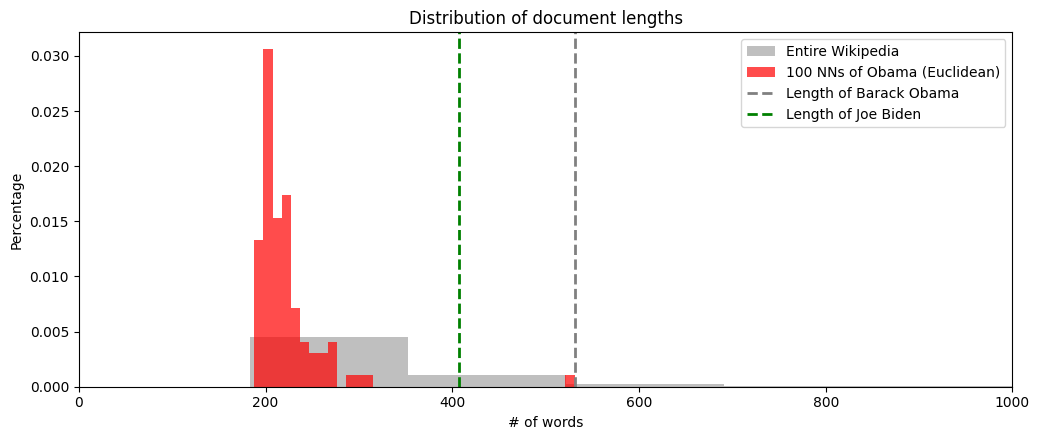

In [270]:
neighbor_lengths = wiki.loc[nearest_neighbors_euclidean.index]['length']
obama_length = wiki[wiki['name'] == 'Barack Obama']['length'].iloc[0]
biden_length = wiki[wiki['name'] == 'Joe Biden']['length'].iloc[0]

plt.figure(figsize=(10.5, 4.5))
plt.hist(wiki['length'], bins=30, alpha=0.5, label='Entire Wikipedia', color='grey', density=True)
plt.hist(neighbor_lengths, bins=35, alpha=0.7, label="100 NNs of Obama (Euclidean)", color='red', density=True)
plt.axvline(obama_length, color='grey', linestyle='dashed', linewidth=2, label="Length of Barack Obama")
plt.axvline(biden_length, color='green', linestyle='dashed', linewidth=2, label="Length of Joe Biden")

plt.xlim(0, 1000)
plt.xlabel('# of words')
plt.ylabel('Percentage')
plt.legend()
plt.title('Distribution of document lengths')
plt.tight_layout()
plt.show()

Relative to the rest of Wikipedia, nearest neighbors of Obama are overwhemingly short, most of them being shorter than 300 words. The bias towards short articles is not appropriate in this application as there is really no reason to  favor short articles over long articles (they are all Wikipedia articles, after all). Many of the Wikipedia articles are 300 words or more, and both Obama and Biden are over 300 words long.

**Note**: For the interest of computation time, the dataset given here contains _excerpts_ of the articles rather than full text. For instance, the actual Wikipedia article about Obama is around 25000 words. Do not be surprised by the low numbers shown in the histogram.

**Note:** Both word-count features and TF-IDF are proportional to word frequencies. While TF-IDF penalizes very common words, longer articles tend to have longer TF-IDF vectors simply because they have more words in them.

To remove this bias, we turn to **cosine distances**:
$$
d(\mathbf{x},\mathbf{y}) = 1 - \frac{\mathbf{x}^T\mathbf{y}}{\|\mathbf{x}\| \|\mathbf{y}\|}
$$
Cosine distances let us compare word distributions of two articles of varying lengths.

**d)** Train a new nearest neighbor model, this time with cosine distances.  Then repeat the search for Obama's 100 nearest neighbors and make a plot to better visualize the effect of having used cosine distance in place of Euclidean on our TF-IDF vectors.

In [271]:
# Your code goes here
wiki['BO-cosine-TF-IDF'] = pairwise_distances(TFIDFmatrix, TFIDFmatrix[obama_idx], metric='cosine').flatten()

nearest_neighbors_cosine = wiki.sort_values(by='BO-cosine-TF-IDF', ascending=True)[['name', 'BO-cosine-TF-IDF']][0:10]
print(nearest_neighbors_cosine)

      name                      BO-cosine-TF-IDF
35817             Barack Obama  1.110223e-15    
24478                Joe Biden  5.735875e-01    
57108   Hillary Rodham Clinton  6.174663e-01    
38376           Samantha Power  6.277340e-01    
38714  Eric Stern (politician)  6.518504e-01    
28447           George W. Bush  6.601642e-01    
39357              John McCain  6.642388e-01    
48693              Artur Davis  6.684870e-01    
18827             Henry Waxman  6.720002e-01    
46811            Jeff Sessions  6.740513e-01    


From a glance at the above table, things look better.  For example, we now see Joe Biden as Barack Obama's nearest neighbor!  We also see Hillary Clinton on the list.  This list looks even more plausible as nearest neighbors of Barack Obama.

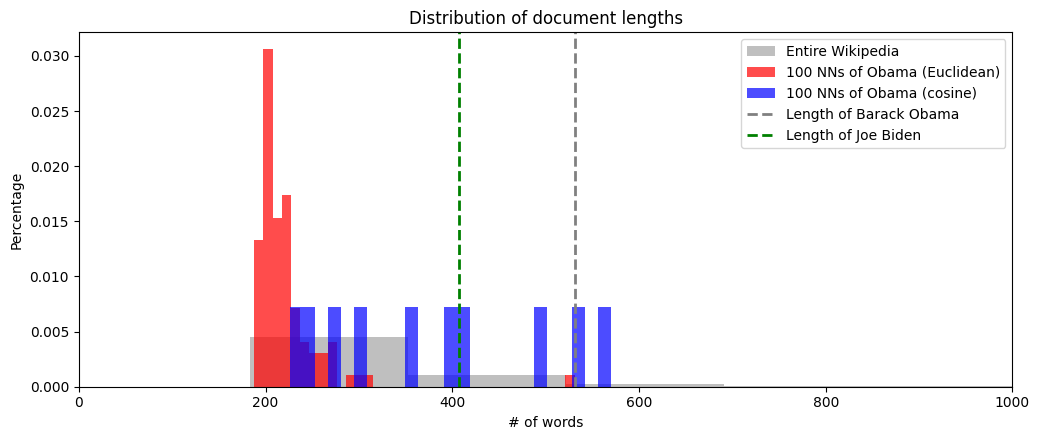

In [272]:
neighbor_lengths_euclidean = wiki.loc[nearest_neighbors_euclidean.index]['length']
neighbor_lengths_cosine = wiki.loc[nearest_neighbors_cosine.index, 'length']

plt.figure(figsize=(10.5, 4.5))
plt.hist(wiki['length'], bins=30, alpha=0.5, label='Entire Wikipedia', color='grey', density=True)
plt.hist(neighbor_lengths_euclidean, bins=35, alpha=0.7, label="100 NNs of Obama (Euclidean)", color='red', density=True)
plt.hist(neighbor_lengths_cosine, bins=25, alpha=0.7, label="100 NNs of Obama (cosine)", color='blue', density=True)
plt.axvline(obama_length, color='grey', linestyle='dashed', linewidth=2, label="Length of Barack Obama")
plt.axvline(biden_length, color='green', linestyle='dashed', linewidth=2, label="Length of Joe Biden")

plt.xlim(0, 1000)
plt.xlabel('# of words')
plt.ylabel('Percentage')
plt.legend()
plt.title('Distribution of document lengths')
plt.tight_layout()
plt.show()

Indeed, the 100 nearest neighbors using cosine distance provide a sampling across the range of document lengths, rather than just short articles like Euclidean distance provided.

**Moral of the story**: In deciding the features and distance measures, check if they produce results that make sense for your particular application.

## Ex. 5: Problem with cosine distances: tweets vs. long articles

Happily ever after? Not so fast. Cosine distances ignore all document lengths, which may be great in certain situations but not in others. For instance, consider the following (admittedly contrived) example.

```
+--------------------------------------------------------+
|                                             +--------+ |
|  One that shall not be named                | Follow | |
|  @username                                  +--------+ |
|                                                        |
|  Democratic governments control law in response to     |
|  popular act.                                          |
|                                                        |
|  8:05 AM - 16 May 2016                                 |
|                                                        |
|  Reply   Retweet (1,332)   Like (300)                  |
|                                                        |
+--------------------------------------------------------+
```

**a)** Transform the tweet into TF-IDF features, using the fit to the Wikipedia dataset. (That is, let's treat this tweet as an article in our Wikipedia dataset and see what happens.) How similar is this tweet to Barack Obama's Wikipedia article? 

In [280]:
df = pd.DataFrame({'text': ['democratic governments control law in response to popular act']})

vectorizer = CountVectorizer(max_features=5000, stop_words='english')
vectorizer.fit(wiki['text'])

tweet_vectorized = vectorizer.transform(df['text'])

tfidf_transformer = TfidfTransformer(smooth_idf=True, norm=None)
tweet_tfidf = tfidf_transformer.fit_transform(tweet_vectorized)

obama_index = wiki[wiki['name'] == 'Barack Obama'].index[0]
obama_tf_idf = tfidf_transformer.transform(vectorizer.transform([wiki.loc[obama_index, 'text']]))

Let's compare this tweet's TF-IDF vectors  to Barack Obama's Wikipedia entry.

In [282]:
feature_names = vectorizer.get_feature_names_out()
non_zero_indices = np.where(obama_tf_idf.toarray() > 0)[1]  
words_with_tfidf = [(feature_names[i], obama_tf_idf[0, i]) for i in non_zero_indices]
sorted_words_with_tfidf = sorted(words_with_tfidf, key=lambda x: x[1], reverse=True)
for word,score in sorted_words_with_tfidf[:10]:
    print(f"Word: {word}, TF-IDF: {score}")

obama_tf_idf

Word: obama, TF-IDF: 15.238324625039509
Word: act, TF-IDF: 8.0
Word: iraq, TF-IDF: 6.772588722239782
Word: military, TF-IDF: 6.772588722239782
Word: president, TF-IDF: 6.772588722239782
Word: law, TF-IDF: 6.0
Word: 2004, TF-IDF: 5.079441541679836
Word: 2009, TF-IDF: 5.079441541679836
Word: 2011, TF-IDF: 5.079441541679836
Word: american, TF-IDF: 5.079441541679836


<1x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 182 stored elements in Compressed Sparse Row format>

**b)** Now, compute the cosine distance between the Barack Obama article and this tweet:

In [275]:
from sklearn.metrics.pairwise import cosine_distances # for one pair of samples we can just use this function

# Your code goes here

Let's compare this distance to the distance between the Barack Obama article and all of its Wikipedia nearest neighbors:

In [276]:
nearest_neighbors_cosine[0:23]

,name,BO-cosine-TF-IDF
35817,Barack Obama,1.110223e-15
24478,Joe Biden,5.735875e-01
57108,Hillary Rodham Clinton,6.174663e-01
38376,Samantha Power,6.277340e-01
38714,Eric Stern (politician),6.518504e-01
28447,George W. Bush,6.601642e-01
39357,John McCain,6.642388e-01
48693,Artur Davis,6.684870e-01
18827,Henry Waxman,6.720002e-01
46811,Jeff Sessions,6.740513e-01


With cosine distances, the tweet is "nearer" to Barack Obama than most people! If someone is reading the Barack Obama Wikipedia page, would you want to recommend they read this tweet?
In practice, it is common to enforce maximum or minimum document lengths. After all, when someone is reading a long article from _The Atlantic_, you wouldn't recommend him/her a tweet.